# Building makemore pt.2: MLP approach

MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!curl -O https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   702k      0 --:--:-- --:--:-- --:--:--  702k


In [ ]:
words = open('names.txt', 'r').read().splitlines()

In [ ]:
len(words)

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [],[]
for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    # print(ch)
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '---->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

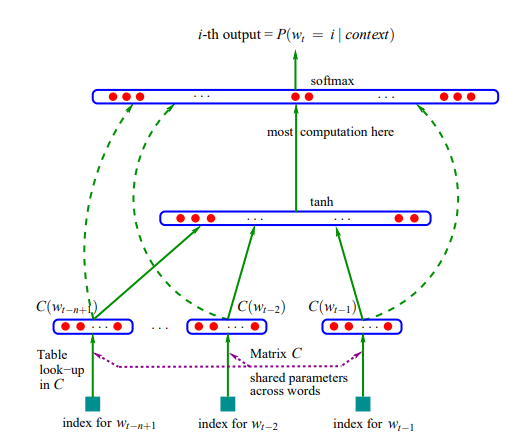

So we have 27 possible characters and we're going to embed them in a lower (2) dimensional space  (27x2).

In other words, each character will have a two-dimensional embedding.

To do this we'll randomly initialize a look-up table C which will be shared across the words. This embedding table will be used to represent a vector space of words. Vectors or words that are in the same span will be considered as words that are similar to each other.

In [ ]:
C = torch.randn((27,2))

In [ ]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.rand((100))

???

In [ ]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [ ]:
h.shape

torch.Size([228146, 100])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.rand((27))

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([228146, 27])

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdim=True)

In [ ]:
prob.shape

torch.Size([228146, 27])

In [ ]:
loss = -prob[torch.arange(228146), Y].log().mean()
loss

tensor(15.6646)

In [ ]:
# --------- reproducibility ------------

In [ ]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lr_used = []
lossi = []
stepi = []

In [ ]:
for i in range(200_000):

  #minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.1 if < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lr_used.append(lre[i])
  lossi.append(loss.log10().item())
  stepi.append(i)

# print(loss.item())

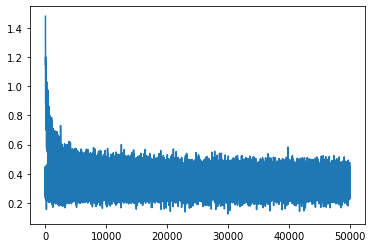

In [ ]:
plt.plot(stepi, lossi)

This is already better than our bigram model that achieved a loss of about **2.49**

In [ ]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1624, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2109, grad_fn=<NllLossBackward0>)

With more parameters, we except to be getting a lower loss. It's possible that we are getting bottlenecked by the embedding layer. Maybe we're just cramming way too many characters into just two dimnesions and the neural net is not able to really use that space effectively.

Since its 2d let's visualize the embeddings that were trained on the neural net on these characters.

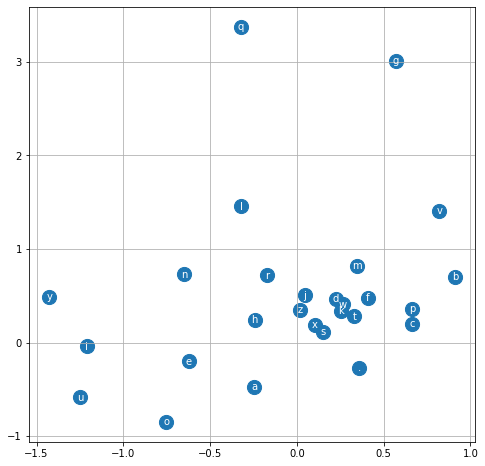

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Our learning rate seems to perform the best at 0.1

*Remember*: 10**-1 = 0.1

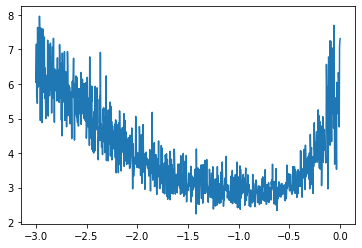

In [ ]:
plt.plot(lr_used, lossi)

**Note**: We said we have a better model because we are achieving a lower loss (2.3176). ***This is not exactly true***. We have a fairly small model with 3481 params, but these models can get larger if we keep adding neurons and params. As the capacity of this neural network grows, it becomes more and more capable of overfitting your training set.

In other words, ***the loss on the training set can get very, very low, as low as zero***. But all that the model is doing is memorizing your training set verbatim.

**The solution is to split up your dataset into three splits.**
*   Training - Used to optimize the parameters in your model using gradient descent
*   Validation/dev - Used for development over all the hyper-parameters of your model; ex: size of hidden layer, size of embedding, strenght of regularization, ...
*   Test - evaluate the performance of the model

**Note**: We only evaluate the loss on the test split very sparringly and very few times because every single time you evaluate your test loss and you learn something from it, you are basically starting to also train on the test split.

In [ ]:
# training, validation/dev, test
# 80%, 10%, 10%

TODO: Improve the validation loss.
- context length - 4
- embedding size - 15
- hidden layer size - 250
- epochs - 300,000
- batch size - 64
- lr decay - 0.1 -> 0.01 -> 0.001 (decreased with every 100,000 epochs)
- skip connection/ direct connection to output layer
- weights initialized with mean=0 and std.=0.1